# Imports

In [1]:
import numpy as np
import pandas as pd
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation from column: ' + title)
    plt.show(block=False)
    
def full_graph(predicted_diff, title):
    predictionsArray = np.asarray(revert_diff(predicted_diff, ts_ie))
    zerosArray = np.zeros(ts_ie.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    
    # plot
    plt.title(title)
    plt.plot(ts_ie.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 4 year prediction')
    plt.ylim([0,15])
    plt.legend()

    plt.show()
    
def revert_diff(predicted_diff, og_data):
    last_value = og_data.iloc[-predicted_diff.size-1][0]
    predicted_actual = np.array([])
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
    return predicted_actual

## Dataprep

In [3]:
ts = pd.read_csv('./data/dataframe_yearly.csv', index_col=0).reset_index()
ts.rename(columns={'Year':'year'}, inplace=True)
ts.set_index('year', inplace=True)

In [4]:
ts_ie = ts[['ice_extent']]

In [5]:
ts

,mean_temp,ice_extent
year,,
1979,6.841667,12.349634
1980,6.625000,12.349545
1981,7.141667,12.147230
1982,6.816667,12.467336
1983,7.766667,12.353095
1984,7.291667,11.920382
1985,7.200000,12.015835
1986,7.533333,12.224548
1987,8.516667,12.183318


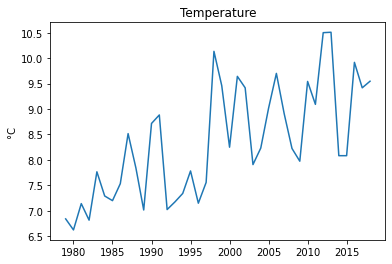

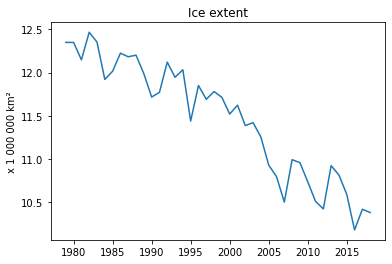

In [6]:
plt.title('Temperature')
plt.plot(ts.iloc[:,0], label='temperature')
plt.ylabel('°C')
plt.show()
plt.title('Ice extent')
plt.ylabel('x 1 000 000 km\u00b2')
plt.plot(ts.iloc[:,1], label='ice extent')

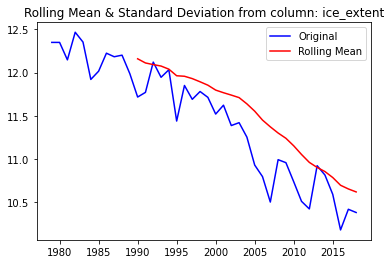

In [7]:
test_stationarity(ts[['ice_extent']], 'ice_extent')

### Differencing

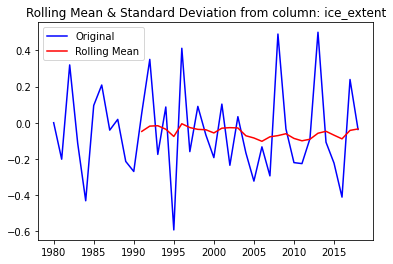

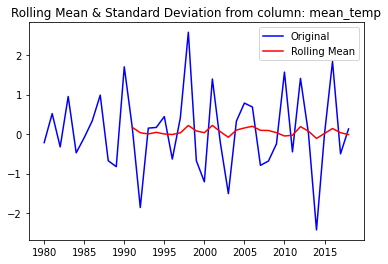

In [8]:
ts_diff = ts - ts.shift(1)
ts_diff = ts_diff.dropna()
test_stationarity(ts_diff[['ice_extent']], 'ice_extent')
test_stationarity(ts_diff[['mean_temp']], 'mean_temp')

Datasets are stationary now

# Cross validation setup

In [9]:
tscv = TimeSeriesSplit(n_splits = 8)
dataset = ts_diff

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 23
TEST: 4

TRAIN: 27
TEST: 4

TRAIN: 31
TEST: 4

TRAIN: 35
TEST: 4



# VARMAX

In [10]:
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))
best_pq = pq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 20:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                # build model
                model = VARMAX(cv_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.forecast(steps=4, dynamic=False)
                prediction_values = predictions[['ice_extent']].values
                true_values = cv_test[['ice_extent']].values
                # error calc
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pq)

# # best range(0,5)
# Best MAE = 0.15358394799986985
# (3, 3)
# Wall time: 9min 27s

In [57]:
best_pq = (3,3)

----
IIII
Mean MAE: 0.154 x 1 000 000 km²
MAE of last prediction: 0.134 x 1 000 000 km²
Execution time: 25.685 seconds


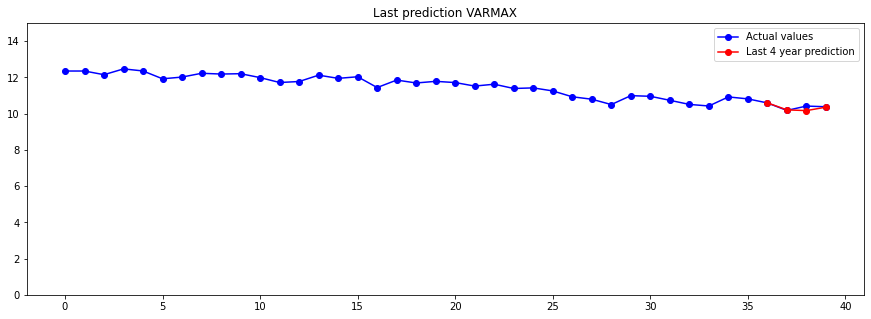

[0.13250395150566072, 0.255018330608453, 0.09309881825606907, 0.13371550021338208]


In [58]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
import timeit
import warnings


start_time = timeit.default_timer()

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("----")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 20:
        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        # build model
        model = VARMAX(cv_train, order=(best_pq))
        model_fit = model.fit()

        # make predictions
        predictions =  model_fit.forecast(steps=4, dynamic=False)
        prediction_values = predictions[['ice_extent']].values
        true_values = cv_test[['ice_extent']].values
        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")
    

time_VARMAX = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_VARMAX = mae_mean
last_MAE_VARMAX = maes[-1]
last_predictions_VARMAX = prediction_values

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_VARMAX)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_VARMAX)
print('Execution time: %.3f seconds' % time_VARMAX)
full_graph(last_predictions_VARMAX, 'Last prediction VARMAX')
print(maes)

# LSTM

In [39]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def predict_LSTM(train, test, n_neurons, n_epochs):
    test['sum'] = test['mean_temp'] + test['ice_extent']


    # define input sequence
    in_seq1 = train.values[:,0]
    in_seq2 = train.values[:,1]
    out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

    # convert to [rows, columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    
    # horizontally stack columns
    dataset = hstack((in_seq1, in_seq2, out_seq))
    
    # choose a number of time steps
    n_steps_in, n_steps_out = 4, 4
    
    # covert into input/output
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    
    # define model
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(n_neurons, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mae')
    
    # fit model
    model.fit(X, y, epochs=n_epochs, verbose=0)
    
    # demonstrate prediction
    x_input = test.values
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat
    

In [109]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
import timeit
import tensorflow as tf

start_time = timeit.default_timer()

# warnings.filterwarnings("ignore") # specify to ignore warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

maes = []
global_maes = []
best_MAE = np.inf


n_neurons_array = [1,5,10,20]
n_epochs_array = [100,200,300]

print("----")

maes = []
for n_neurons in n_neurons_array:
    for n_epochs in n_epochs_array:
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 20:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                yhat = predict_LSTM(cv_train, cv_test, n_neurons, n_epochs)


                prediction_values = yhat[0][:,1]
                true_values = cv_test[['ice_extent']].values

                # error calc
                maes.append(mean_absolute_error(true_values, prediction_values))

                print("I",end="")
        time_LSTM = timeit.default_timer() - start_time
        MAE_LSTM = np.mean(maes)
        last_MAE_LSTM = maes[-1]
        global_maes.append(MAE_LSTM)

        if best_MAE > MAE_LSTM:
            best_n_neurons = n_neurons
            best_n_epochs = n_epochs
            best_MAE = MAE_LSTM

        print()
        print(n_neurons)
        print(n_epochs)
        print(MAE_LSTM)
        print()    

print('Best:')
print('N neurons')
print(best_n_neurons)
print('Epochs size')
print(best_n_epochs)
print('MAE')
print(best_MAE)

In [41]:
best_n_neurons, best_n_epochs = 1, 200

----
IIII
Mean MAE: 0.200 x 1 000 000 km²
MAE of last prediction: 0.210 x 1 000 000 km²
Execution time: 41.617 seconds


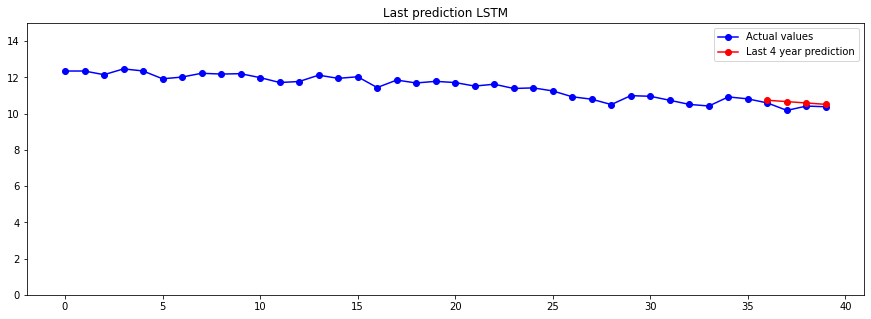

[0.14411208071264658, 0.24311231278801904, 0.20436435040655798, 0.20952587437320158]


In [42]:
from sklearn.metrics import mean_absolute_error
import timeit
import tensorflow as tf

start_time = timeit.default_timer()

# warnings.filterwarnings("ignore") # specify to ignore warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


print("----")

maes = []

for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        yhat = predict_LSTM(cv_train, cv_test, best_n_neurons, best_n_epochs)


        prediction_values = yhat[0][:,1]
        true_values = cv_test[['ice_extent']].values

        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")
    

time_LSTM = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_LSTM = mae_mean
last_MAE_LSTM = maes[-1]
last_predictions_LSTM = prediction_values

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_LSTM)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_LSTM)
print('Execution time: %.3f seconds' % time_LSTM)
full_graph(last_predictions_LSTM, 'Last prediction LSTM')
print(maes)

# Prophet

In [ ]:
# formatting dataframe
ts_formated_prophet = ts_diff.reset_index().rename(columns = {'year' : 'ds', 'ice_extent' : 'y'})
ts_formated_prophet['ds'] = pd.DataFrame(pd.to_datetime(ts_formated_prophet['ds'].astype(str), format='%Y'))

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('mean_temp')
m.fit(df_train)

In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore") # specify to ignore warning messages

# define dataframe
df = ts_formated_prophet

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 2, 5, 10, 15, 20, 25],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# initialize variables
maes = []  
global_maes = []
best_MAE_prophet = np.inf

# Use cross validation to evaluate all parameters
for params in all_params:

    # loop trough all split time series that have a trainingsset with more than 20 values
    for train_index, test_index in tscv.split(ts_formated_prophet):    
        if train_index.size > 20:  

            # initialize cross validation train and test sets
            train  = ts_formated_prophet.iloc[train_index]
            y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
            X_test = ts_formated_prophet.iloc[test_index][['ds','mean_temp']]

            # Fit model with given params
            model = Prophet(weekly_seasonality=False, daily_seasonality=False)
            model = model.add_regressor('mean_temp')
            model = model.fit(train)

            # make predictions
            forecast = model.predict(X_test)
            y_pred = forecast['yhat'].values

            # last actual prediction 
            last_prediction_prophet = y_pred

            # error calculation this part of the cross validation
            maes.append(mean_absolute_error(y_test, y_pred))
    
    # error calculation for this parameter combination
    MAE_prophet = np.mean(maes)
    last_MAE_prophet = maes[-1]
    global_maes.append(MAE_prophet)
    
    # logging
    print('changepoint_prior_scale: ' + str(params['changepoint_prior_scale']))
    
    # store parameters resulting in the lowest mean MAE
    if best_MAE_prophet > MAE_prophet:
        best_params = params
        best_MAE_prophet = MAE_prophet

# log optimal result          
print('changepoint_prior_scale: ' + str(best_params['changepoint_prior_scale']))
print(best_MAE_prophet)

In [57]:
maes = []
global_maes = []

from sklearn.metrics import mean_absolute_error

# loop trough all split time series that have a trainingsset with more than 20 values
for train_index, test_index in tscv.split(ts_formated_prophet):    
    if train_index.size > 20:  

        # initialize cross validation train and test sets
        train  = ts_formated_prophet.iloc[train_index]
        y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
        X_test = ts_formated_prophet.iloc[test_index][['ds','mean_temp']]

        # Fit model with given params
        model = Prophet(weekly_seasonality=False, daily_seasonality=False)
        model = model.add_regressor('mean_temp')
        model = model.fit(train)

        # make predictions
        forecast = model.predict(X_test)
        y_pred = forecast['yhat'].values

        # last actual prediction 
        last_prediction_prophet = y_pred

        # error calculation this part of the cross validation
        maes.append(mean_absolute_error(y_test, y_pred))

# error calculation for this parameter combination
MAE_prophet = np.mean(maes)
last_MAE_prophet = maes[-1]
global_maes.append(MAE_prophet)
print(np.mean(maes))

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
C:\Users\Emiel\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
C:\Users\Emiel\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
C:\Users\Emiel\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it 

0.1888094057693068


In [34]:
# formatting dataframe
ts_formated_prophet = ts_diff.reset_index().rename(columns = {'year' : 'ds', 'ice_extent' : 'y'})
ts_formated_prophet['ds'] = pd.DataFrame(pd.to_datetime(ts_formated_prophet['ds'].astype(str), format='%Y'))

In [39]:
df_train = ts_formated_prophet.iloc[:-4]
df_test  = ts_formated_prophet.iloc[-4:]

In [40]:
df_train.head()

,ds,mean_temp,y
0,1980-01-01,-0.216667,-0.000089
1,1981-01-01,0.516667,-0.202316
2,1982-01-01,-0.325000,0.320107
3,1983-01-01,0.950000,-0.114241
4,1984-01-01,-0.475000,-0.432713


In [41]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('mean_temp')
m.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Emiel\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [43]:
forecast = m.predict(df_test.drop(columns="y"))
forecast.set_index('ds')[['yhat']]

,yhat
ds,
2015-01-01,-0.046999
2016-01-01,-0.113558
2017-01-01,-0.036017
2018-01-01,-0.057954


In [ ]:
# example

In [2]:
import pandas as pd
df = pd.DataFrame(pd.date_range(start="2019-09-01", end="2019-09-30", freq='D', name='ds'))
df["y"] = range(1,31)
df["add1"] = range(101,131)
df["add2"] = range(201,231)
df.head()

,ds,y,add1,add2
0,2019-09-01,1,101,201
1,2019-09-02,2,102,202
2,2019-09-03,3,103,203
3,2019-09-04,4,104,204
4,2019-09-05,5,105,205


In [3]:
df_train = df.loc[df["ds"]<"2019-09-21"]
df_test  = df.loc[df["ds"]>="2019-09-21"]

In [4]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('add1')
m.add_regressor('add2')
m.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
C:\Users\Emiel\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
forecast = m.predict(df_test.drop(columns="y"))
forecast.set_index('ds')[['yhat']]

,yhat
ds,
2019-09-21,21.005198
2019-09-22,22.013949
2019-09-23,23.026550
2019-09-24,24.026550
2019-09-25,25.026550
2019-09-26,26.026550
2019-09-27,27.026550
2019-09-28,28.031748
2019-09-29,29.040499


### Evaluation

In [112]:
# formatting
results = [[MAE_VARMAX, time_VARMAX, last_MAE_VARMAX],
           [MAE_LSTM, time_LSTM, last_MAE_LSTM]]

# display results
results = pd.DataFrame(results, columns=['Mean MAE (x 1 000 000 km\u00b2)','Execution time (s)','Last MAE (x 1 000 000 km\u00b2)']
             ,index=['VARMAX','LSTM']).round(decimals=3)
results

,Mean MAE (x 1 000 000 km²),Execution time (s),Last MAE (x 1 000 000 km²)
VARMAX,0.154,49.062,0.134
LSTM,0.198,26.708,0.210


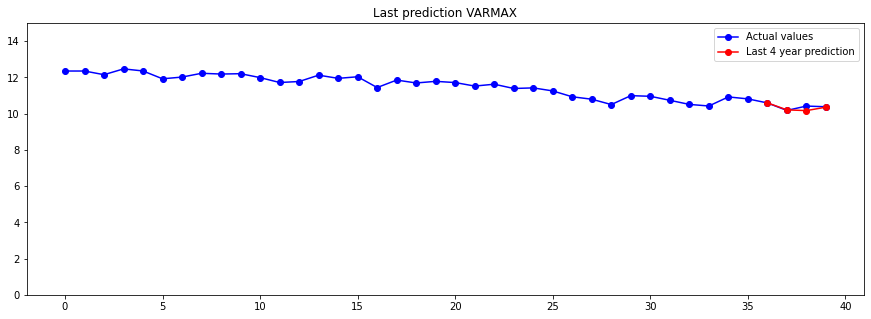

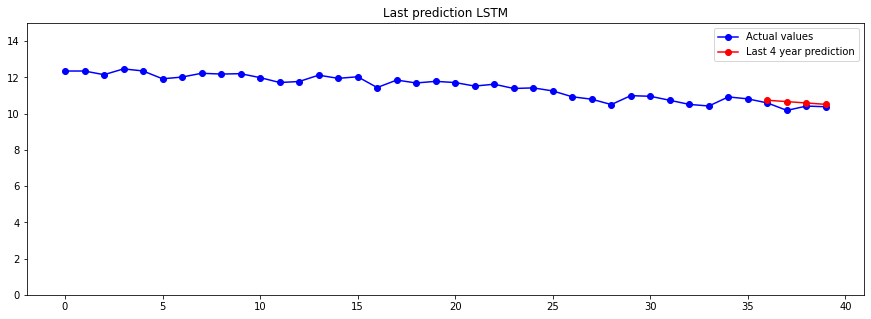

In [65]:
full_graph(last_predictions_VARMAX, 'Last prediction VARMAX')
full_graph(last_predictions_LSTM, 'Last prediction LSTM')